<a href="https://colab.research.google.com/github/lbrilh/Bitcoin-Saving/blob/main/TSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Time Series Forecast of Store Sales using Additive Model**

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.deterministic import CalendarFourier
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.ar_model import AutoReg
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf

from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
data_dir = "/content/drive/MyDrive/TSA/Data"
train_dir = data_dir + "/train.csv"

train_df = pd.read_csv(train_dir)
#train_df.head()

In [3]:
test_dir = data_dir + "/test.csv"
test_df = pd.read_csv(test_dir)
#test_df.head()

In [4]:
store_sales = train_df.copy()
store_sales = store_sales.set_index('date')
store_sales.index = pd.to_datetime(store_sales.index)

# Data preprocessing

In [5]:
dummy_daily = store_sales["sales"].groupby(["date"]).mean() # average daily spendings
dummy_daily_df = dummy_daily.to_frame()
print(type(dummy_daily_df))
dummy_daily_df.head()

<class 'pandas.core.frame.DataFrame'>


,sales
date,
2013-01-01,1.409438
2013-01-02,278.390807
2013-01-03,202.840197
2013-01-04,198.911154
2013-01-05,267.873244


In [6]:
# find outliers
dummy_daily_df.quantile([0.01, 0.99])

,sales
0.01,153.113364
0.99,682.320117


# Test for lag and time features

In [7]:
# avg daily prices with outlier correction
avg_daily = dummy_daily_df[(dummy_daily_df["sales"] > 153) & (dummy_daily_df["sales"] < 683)].dropna()

# no outlier correction
# avg_daily = dummy_daily.dropna()

In [8]:
avg_daily.head()

,sales
date,
2013-01-02,278.390807
2013-01-03,202.840197
2013-01-04,198.911154
2013-01-05,267.873244
2013-01-06,291.636028


<Axes: xlabel='date'>

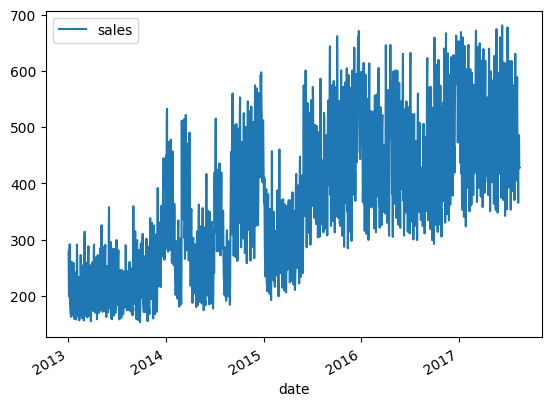

In [9]:
# crate time plot to observe overall trend in average prices over time
avg_daily.plot()

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

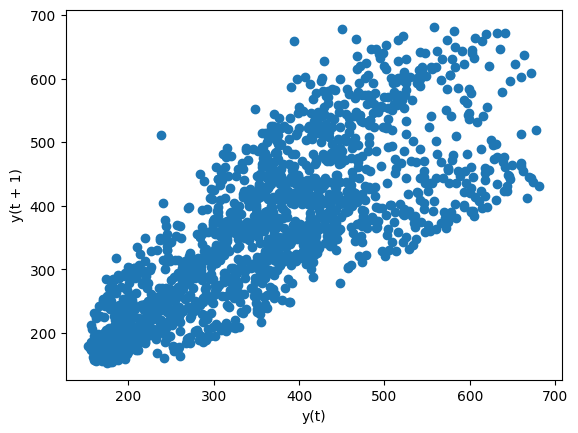

In [10]:
# create lag plot to check for lag-correlation
pd.plotting.lag_plot(avg_daily.squeeze(), lag=1)

# Moving average plot

## Create yearly moving average plot

The yearly moving average plot indicates a very slow growing cubic trend


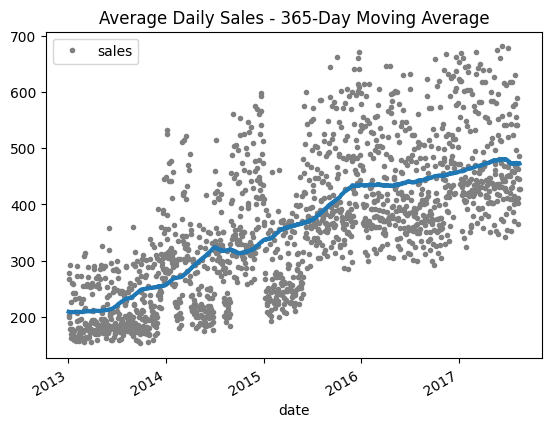

In [79]:
moving_average = avg_daily['sales'].rolling(window=365,center=True,min_periods=183).mean()
ax = avg_daily.plot(style=".", color="0.5")
moving_average.plot(ax=ax, linewidth=3, title="Average Daily Sales - 365-Day Moving Average", legend=False,)
print("The yearly moving average plot indicates a very slow growing cubic trend")

## Verify observed trend & Detrend time series

In [80]:
# Create covariables to fit a polynomial of order...
dp = DeterministicProcess(
    index=avg_daily.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend,trend_squared,trend_cubed
date,,,,
2013-01-02,1.0,1.0,1.0,1.0
2013-01-03,1.0,2.0,4.0,8.0
2013-01-04,1.0,3.0,9.0,27.0
2013-01-05,1.0,4.0,16.0,64.0
2013-01-06,1.0,5.0,25.0,125.0


In [81]:
y = avg_daily["sales"]
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

trend_pred = pd.Series(model.predict(X), index=X.index)

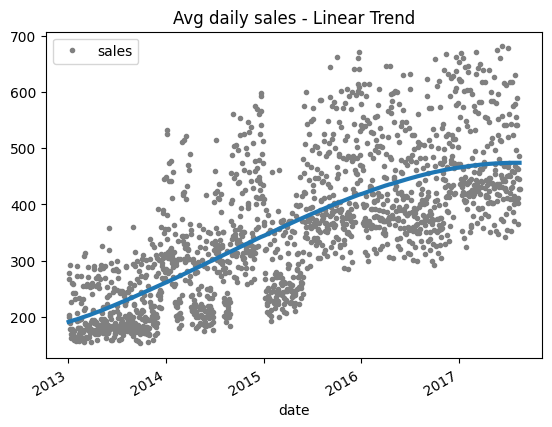

In [82]:
ax = avg_daily.plot(style=".", color="0.5", title="Avg daily sales - Linear Trend")
_ = trend_pred.plot(ax=ax, linewidth=3, label="Trend")

Text(0, 0.5, 'sales')

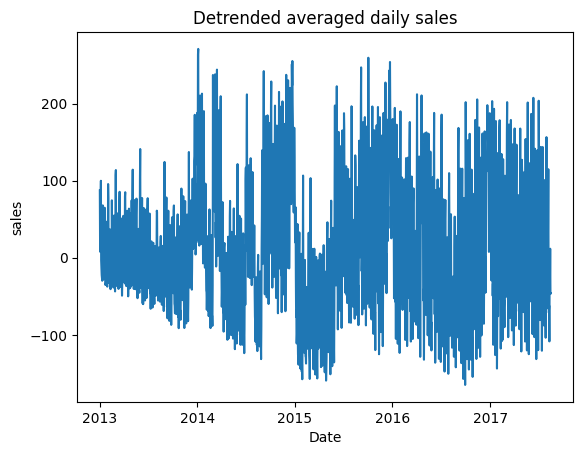

In [83]:
_ = plt.plot(avg_daily.index, avg_daily["sales"]-trend_pred)
plt.title("Detrended averaged daily sales")
plt.xlabel("Date")
plt.ylabel("sales")

In [84]:
avg_daily_detrended = (avg_daily["sales"] - trend_pred).to_frame()

In [85]:
type(avg_daily_detrended)

pandas.core.frame.DataFrame

In [86]:
avg_daily_detrended.head()

,0
date,
2013-01-02,87.324622
2013-01-03,11.604484
2013-01-04,7.505693
2013-01-05,76.297816
2013-01-06,99.890414


In [87]:
avg_daily_detrended.columns = ["sales"]

In [88]:
avg_daily_detrended.head()

,sales
date,
2013-01-02,87.324622
2013-01-03,11.604484
2013-01-04,7.505693
2013-01-05,76.297816
2013-01-06,99.890414


## Forecast MA / Trend

In [89]:
X_test_trend = dp.out_of_sample(steps=16)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [93]:
y_pred_trend = pd.Series(model.predict(X_test_trend), index = pd.date_range(start='08/16/2017', end='08/31/2017'))

# Test for seasonality

## Definition: Seasonal plot and Periodogramm

In [36]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

## Seasonal Plot

<ipython-input-24-48ce0ac8971f>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  X["week"] = X["date"].dt.weekofyear  # the seasonal period (period)
<ipython-input-23-4181c209cea6>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(
<ipython-input-23-4181c209cea6>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(


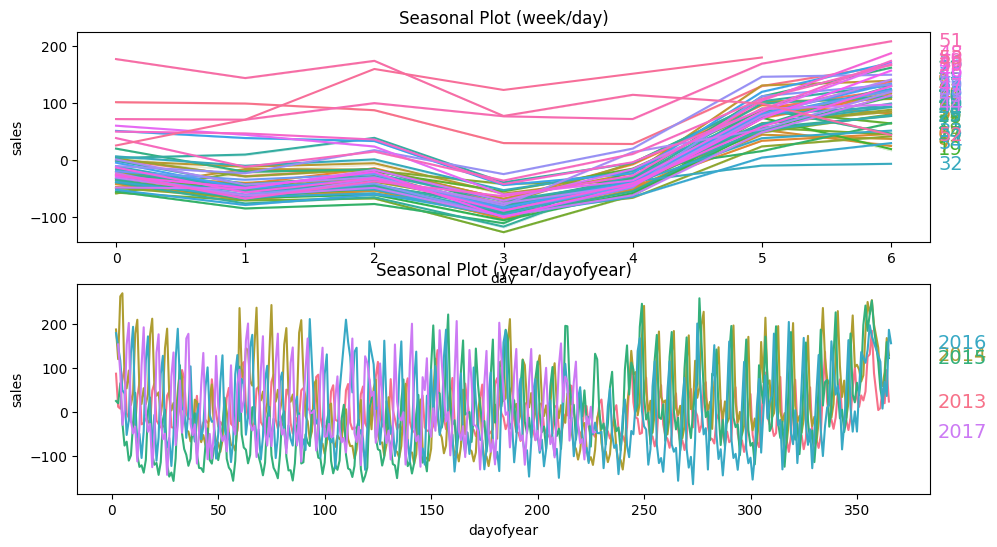

In [24]:
X = avg_daily_detrended.squeeze()
X = X.reset_index()
X["date"] = pd.to_datetime(X["date"])

# days within a week
X["day"] = X["date"].dt.dayofweek # the x-axis (freq)
X["week"] = X["date"].dt.weekofyear  # the seasonal period (period)

# days within a year
X["dayofyear"] = X["date"].dt.dayofyear
X["year"] = X["date"].dt.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);

# observe strong weekly season and some small yearly season

## Periodogramm

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

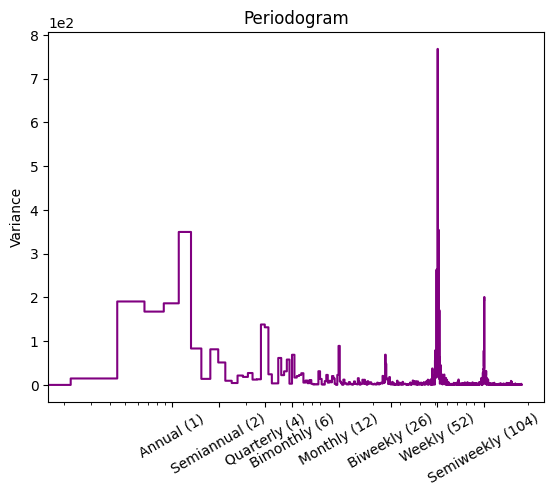

In [25]:
plot_periodogram(avg_daily_detrended["sales"])

# observe a peaks in weekly and annual.
# model weekly via indicator (too little observations)
# model annual via fourier
# From left to right it drops off after monthly --> 12 features for fourier

## Feature Extration

In [26]:
fourier = CalendarFourier(freq="A", order=12)  # 12 sin/cos pairs for "A"nnual seasonality

In [27]:
type(avg_daily_detrended.squeeze().index)

pandas.core.indexes.datetimes.DatetimeIndex

In [28]:
# feature extraction
## add annual seasonality via additonal_terms
dp = DeterministicProcess(
    index=avg_daily.squeeze().index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear) / the time dummy
    period = 51,                 # 52 (weeks) indicators and linear regression --> drop one indicator
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True                    # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in avg_daily_detrended.index

In [29]:
X.head()

,const,trend,"s(2,51)","s(3,51)","s(4,51)","s(5,51)","s(6,51)","s(7,51)","s(8,51)","s(9,51)",...,"sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)","sin(11,freq=A-DEC)","cos(11,freq=A-DEC)","sin(12,freq=A-DEC)","cos(12,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.137279,0.990532,0.154309,0.988023,0.171293,0.985220,0.188227,0.982126,0.205104,0.978740
2013-01-03,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.271958,0.962309,0.304921,0.952378,0.337523,0.941317,0.369725,0.929141,0.401488,0.915864
2013-01-04,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.401488,0.915864,0.448229,0.893919,0.493776,0.869589,0.538005,0.842942,0.580800,0.814046
2013-01-05,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.523416,0.852078,0.580800,0.814046,0.635432,0.772157,0.687053,0.726608,0.735417,0.677615
2013-01-06,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.635432,0.772157,0.699458,0.714673,0.758306,0.651899,0.811539,0.584298,0.858764,0.512371


In [30]:
y = avg_daily_detrended["sales"]
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

season_pred = pd.Series(model.predict(X), index=X.index)

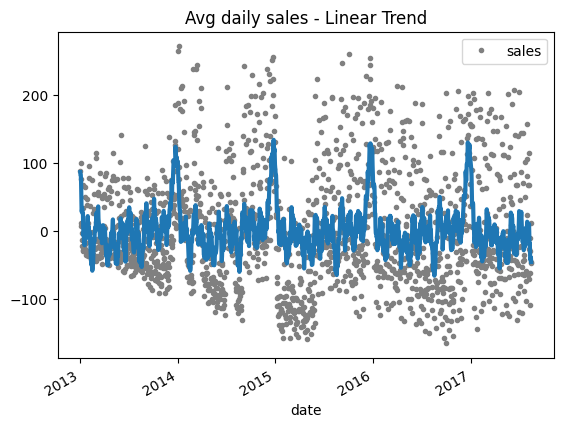

In [31]:
ax = avg_daily_detrended.plot(style=".", color="0.5", title="Avg daily sales - Linear Trend")
_ = season_pred.plot(ax=ax, linewidth=3, label="Trend")

In [32]:
detrended_deseasonalized = (avg_daily_detrended["sales"] - season_pred).to_frame()
detrended_deseasonalized.columns = ["sales"]
detrended_deseasonalized.head()

,sales
date,
2013-01-02,1.046603
2013-01-03,-70.579090
2013-01-04,-74.339258
2013-01-05,4.146589
2013-01-06,50.971802


<Axes: xlabel='date'>

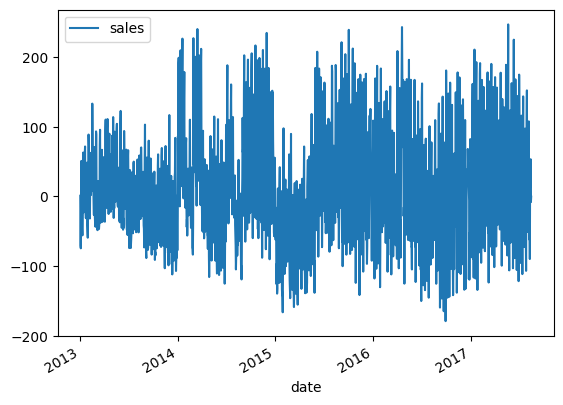

In [33]:
detrended_deseasonalized.plot()

### Forecasting Season

In [34]:
X_test_season = dp.out_of_sample(steps=16, forecast_index = pd.date_range(start='08/16/2017', end='08/31/2017'))

In [35]:
y_pred_season = pd.Series(model.predict(X_test_season), index = X_test_season.index)

# Time Series as feature

## Plot initalization

In [37]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


## Lag Plots / (Partial-)Autocorrelation

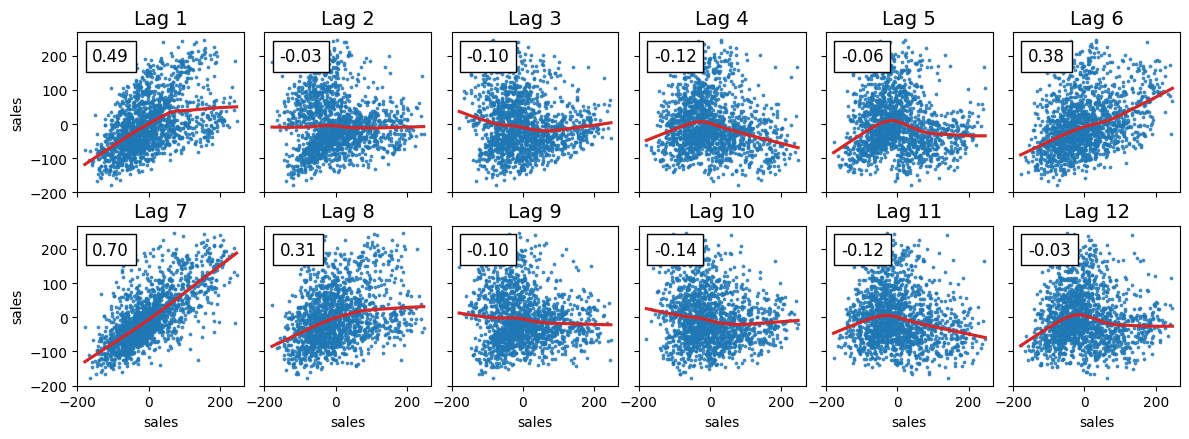

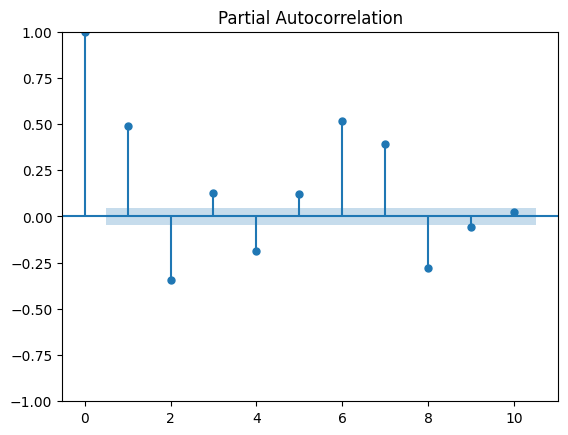

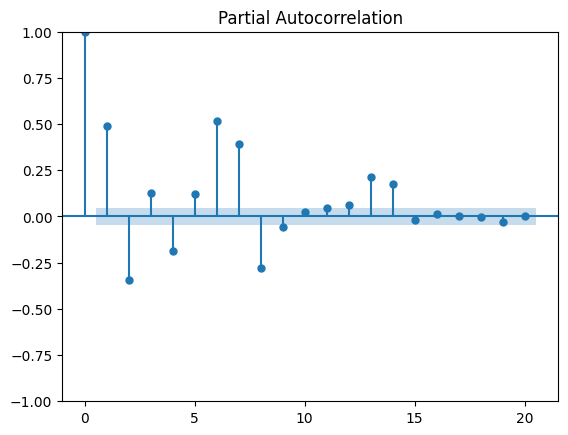

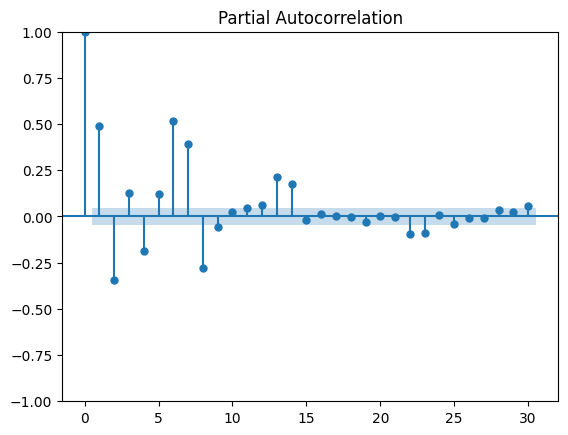

In [38]:
_ = plot_lags(detrended_deseasonalized["sales"], lags=12, nrows=2)


# the first 8 lags seem to be important
i = 10
while i < 40:
  _ = plot_pacf(detrended_deseasonalized["sales"], lags=i)
  i += 10

## Forecast Cycle

In [39]:
res = AutoReg(detrended_deseasonalized["sales"], lags = 8, trend = "n").fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [101]:
len(res.params)

8

In [115]:
# forecast
n = 16
preds = detrended_deseasonalized["sales"].iloc[-8:].to_numpy()
y_pred_cycle = np.zeros(n)

In [117]:
for i in range(0,16):
  sum = np.sum(res.params*np.flip(preds[-8:])) # lag1 is last element in array preds
  preds = np.append(preds,sum)
  y_pred_cycle[i] = sum

In [119]:
y_pred_cycle = pd.Series(y_pred_cycle, index = X_test_season.index)

# Predicting

In [120]:
y_submission = y_pred_trend + y_pred_season + y_pred_cycle

In [123]:
y_submission.to_csv(data_dir + '/submission.csv', index=False)

<Axes: >

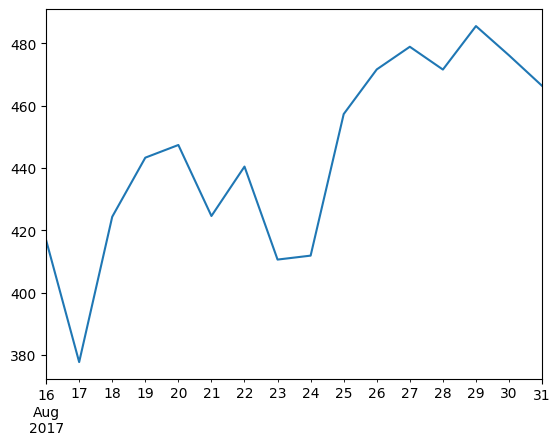

In [121]:
y_submission.plot()